In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import pydicom
import chainer
import chainercv
from chainercv.visualizations import vis_bbox
from chainercv.datasets import VOCBboxDataset
from tqdm import tqdm

In [3]:
train_images = glob.glob('./data/stage_1_train_images/*dcm')
test_images = glob.glob('./data/stage_1_test_images/*dcm')
df_detailed_class_info = pd.read_csv('./data/stage_1_detailed_class_info.csv')
df_train_labels = pd.read_csv('./data/stage_1_train_labels.csv')
df_sample_submission = pd.read_csv('./data/stage_1_sample_submission.csv')

In [4]:
df_detailed_class_info.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [5]:
df_train_labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [6]:
df_sample_submission.head()

,patientId,PredictionString
0,000924cf-0f8d-42bd-9158-1af53881a557,0.5 0 0 100 100
1,000db696-cf54-4385-b10b-6b16fbb3f985,0.5 0 0 100 100
2,000fe35a-2649-43d4-b027-e67796d412e0,0.5 0 0 100 100
3,001031d9-f904-4a23-b3e5-2c088acd19c6,0.5 0 0 100 100
4,0010f549-b242-4e94-87a8-57d79de215fc,0.5 0 0 100 100


In [7]:
df_train_labels['Target'].unique()

array([0, 1])

In [8]:
len(df_train_labels['patientId'].unique())

25684

In [9]:
len(train_images)

25684

In [10]:
len(df_train_labels)

28989

In [11]:
len(df_detailed_class_info)

28989

In [12]:
df_train_labels.head(20)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [13]:
df_detailed_class_info.head(20)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [14]:
df_train_info = pd.concat([df_train_labels, df_detailed_class_info[['class']]], axis=1)
df_train_info.head(10)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity


In [15]:
df_train_info['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [16]:
df_train_info.dropna()['class'].unique()

array(['Lung Opacity'], dtype=object)

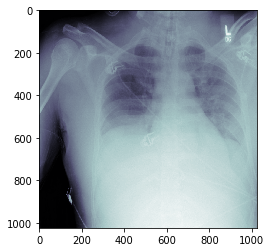

In [17]:
ds = pydicom.dcmread(train_images[0])
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
plt.show()

In [18]:
ds.pixel_array

array([[  0,   0,   1, ...,  26,  33,   9],
       [  1,   1,   1, ...,  54,  60,  36],
       [  1,   1,   2, ...,  53,  57,  32],
       ...,
       [ 37,  46,  26, ..., 124, 126,  70],
       [ 40,  49,  28, ..., 123, 129,  78],
       [ 18,  29,  12, ...,  57,  71,  30]], dtype=uint8)

In [19]:
ds.pixel_array.shape

(1024, 1024)

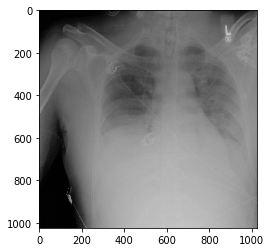

In [20]:
img = np.zeros((ds.pixel_array.shape[0], ds.pixel_array.shape[1], 3), dtype=np.uint8)
img[:, :, 0] = ds.pixel_array
img[:, :, 1] = ds.pixel_array
img[:, :, 2] = ds.pixel_array

plt.imshow(img)
plt.show()

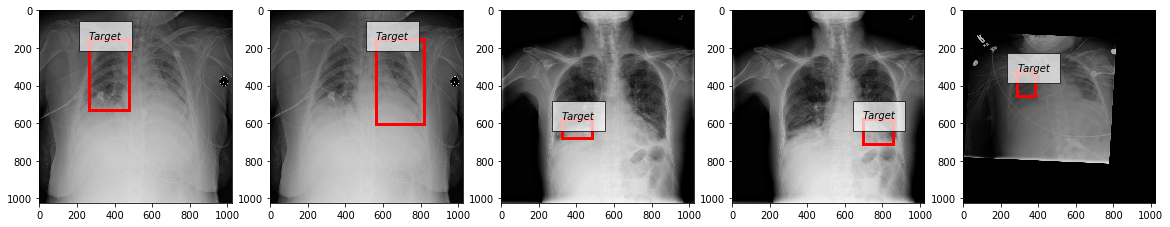

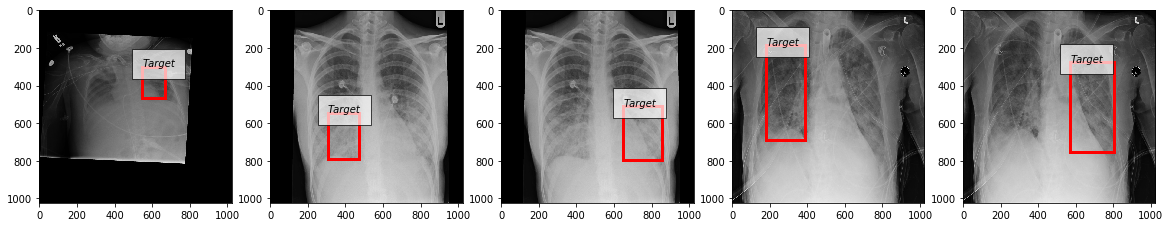

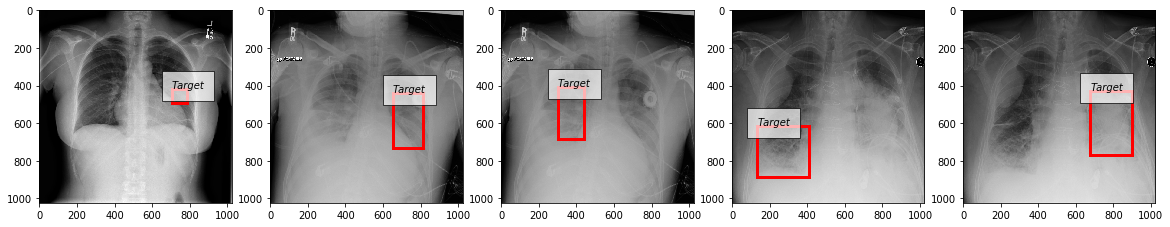

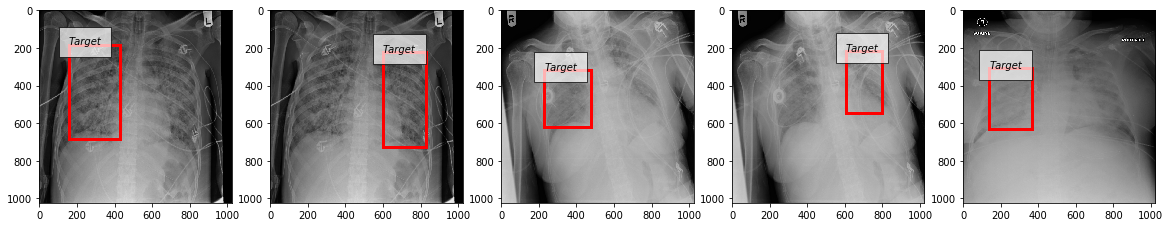

In [21]:
df_tmp = df_train_labels.copy()

cnt = 0

for i, row in df_tmp.dropna().iterrows():
    
    if cnt % 5 == 0:
        fig, axs = plt.subplots(ncols=5, figsize=(20, 5))
    
    x = row['x']
    y = row['y']
    w = row['width']
    h = row['height']
    xmin = x
    ymin = y
    xmax = x+w
    ymax = y+h
    
    bbox = np.array([[ymin, xmin, ymax, xmax]], dtype=np.float32)
    
    patiend_id = row['patientId']
    img_path = './data/stage_1_train_images/' + patiend_id + '.dcm'
    ds = pydicom.dcmread(img_path)
    img = ds.pixel_array.astype(np.float32)
    
    img_tmp = np.zeros((3, img.shape[0], img.shape[1]), dtype=np.uint8)
    img_tmp[0, :, :] = img
    img_tmp[1, :, :] = img
    img_tmp[2, :, :] = img
    img = img_tmp
    
    labels = np.array([0], dtype=np.int32)
    
    vis_bbox(img, bbox, labels, label_names=('Target', 'none'), ax=axs[cnt%5])
    
    cnt += 1
    if cnt+1 > 20:
        break

plt.show()

In [22]:
exchange_patient_id_list = np.unique(df_train_info.dropna()['patientId'])
len(exchange_patient_id_list)

5659

In [23]:
len(test_images)

1000

In [24]:
np.random.seed(0)
indices = np.random.permutation(len(exchange_patient_id_list))
train_patient_ids = exchange_patient_id_list[indices[:4000]]
valid_patient_ids = exchange_patient_id_list[indices[4000:]]
len(train_patient_ids), len(valid_patient_ids)

(4000, 1659)

In [35]:
!mkdir -p ./data/voc/ImageSets/Main
!mkdir ./data/voc/Annotations
!mkdir ./data/voc/JPEGImages

In [36]:
!ls ./data/voc

Annotations  ImageSets	JPEGImages


In [37]:
txt = ''
for id_ in train_patient_ids:
    
    txt += id_ + '\n'
    
f = open('./data/voc/ImageSets/Main/train.txt', 'w')
f.write(txt)
f.close()

In [38]:
txt = ''
for id_ in valid_patient_ids:
    
    txt += id_ + '\n'
    
f = open('./data/voc/ImageSets/Main/val.txt', 'w')
f.write(txt)
f.close()

In [39]:
txt = ''
for id_ in train_patient_ids:
    
    txt += id_ + '\n'
    
for id_ in valid_patient_ids:
    
    txt += id_ + '\n'
    
f = open('./data/voc/ImageSets/Main/trainval.txt', 'w')
f.write(txt)
f.close()

In [40]:
!ls ./data/voc/ImageSets/Main/

train.txt  trainval.txt  val.txt


In [41]:
# save xml

for id_ in tqdm(exchange_patient_id_list):
    
    ds = pydicom.dcmread('./data/stage_1_train_images/'+id_+'.dcm')
    h, w = ds.pixel_array.shape
    
    folder = 'voc'
    filename = id_ + '.jpg'
    
    xml = '<annotation>'
    xml += '\n\t<folder>' + folder + '</folder>'
    xml += '\n\t<filename>' + filename + '</filename>'
    xml += '\n\t<source>\n\t\t<database>Unknown</database>\n\t</source>'
    xml += '\n\t<size>'
    xml += '\n\t\t<width>' + str(w) + '</width>'
    xml += '\n\t\t<height>' + str(h) + '</height>'
    xml += '\n\t</size>'
    xml += '\n\t<segmented>0</segmented>'
    
    df_tmp = df_train_info[df_train_info['patientId'].isin([id_])]
    for i, row in df_tmp.iterrows():
        
        xmin = row['x']
        ymin = row['y']
        xmax = xmin + row['width']
        ymax = ymin + row['height']
        
        xml += '\n\t<object>'
        xml += '\n\t\t<name>Target</name>'
        xml += '\n\t\t<bndbox>'
        xml += '\n\t\t\t<xmin>' + str(int(xmin)) + '</xmin>'
        xml += '\n\t\t\t<xmax>' + str(int(xmax)) + '</xmax>'
        xml += '\n\t\t\t<ymin>' + str(int(ymin)) + '</ymin>'
        xml += '\n\t\t\t<ymax>' + str(int(ymax)) + '</ymax>'
        xml += '\n\t\t</bndbox>'
        xml += '\n\t</object>'
        
    xml += '\n</annotation>'
    
    f = open('./data/voc/Annotations/' + id_ + '.xml', 'w')
    f.write(xml)
    f.close()

100%|██████████| 5659/5659 [01:38<00:00, 57.42it/s]


In [42]:
import subprocess

In [43]:
# convert dcm to jpeg
# using imagemagick

for id_ in tqdm(exchange_patient_id_list):

    img_path = './data/stage_1_train_images/' + id_ + '.dcm'
    jpg_path = './data/stage_1_train_images/' + id_ + '.jpg'
    
    subprocess.call('mogrify -format jpg '+img_path, shell=True)
    subprocess.call('mv '+jpg_path+' ./data/voc/JPEGImages/', shell=True)    

100%|██████████| 5659/5659 [04:39<00:00, 20.52it/s]


In [44]:
# using as Pascal VOC format by tensorflow object detection api

dataset = VOCBboxDataset(data_dir='./data/voc')